## Preparing Data

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import torch
import torchtext
from torchtext import data
import spacy
import os
import re

spacy.load('en')
_stopwords = spacy.lang.en.stop_words.STOP_WORDS

os.environ['OMP_NUM_THREADS'] = '4'


SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

TEXT = data.Field(lower=True,include_lengths=False,tokenize='spacy')

LABEL = data.Field(sequential=False, 
                         use_vocab=False, 
                         pad_token=None, 
                            unk_token=None, dtype = torch.float)


dataFields = {"comment_text": ("comment_text", TEXT), 
              'toxic': ("toxic", LABEL), 
              'severe_toxic': ("severe_toxic", LABEL),
              'threat': ("threat", LABEL), 
              'obscene': ("obscene", LABEL),
              'insult': ("insult", LABEL), 
              'identity_hate': ("identity_hate", LABEL)}

dataset= data.TabularDataset(path='./data/toxic/train.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=True)

In [2]:
import random
SEED = 3
#train, unimportant = dataset.split(split_ratio=0.5,random_state = random.seed(SEED)) 

train_data, val_data = dataset.split(split_ratio=0.9,random_state = random.seed(SEED))

In [3]:
MAX_VOCAB_SIZE = 20_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

In [4]:
BATCH_SIZE = 256

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, val_data), 
    batch_size = BATCH_SIZE,
    sort_key=lambda x: len(x.comment_text),
    sort_within_batch = True,
    device = device)

In [5]:
yFields = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
iaux=0
for batch in valid_iterator:
    iaux+=1
    aux = batch
    aux2= torch.stack([getattr(batch, y) for y in yFields])
    if iaux==20: break

In [6]:

        
torch.transpose( torch.stack([getattr(aux, y) for y in yFields]),0,1)

tensor([[0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [7]:
aux.comment_text[0].size()

torch.Size([256])

In [8]:
aux.toxic.size()

torch.Size([256])

## Build model

In [9]:
import torch.nn as nn
from torch.functional import F
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)


In [10]:


INPUT_DIM = len(TEXT.vocab) # 20002
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = 6
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 1

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES ,OUTPUT_DIM, DROPOUT, PAD_IDX)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,092,306 trainable parameters


In [12]:
for i in train_iterator:
    aux=i
    break

from torchsummaryX import summary
print(aux.comment_text.size())
summary(model, aux.comment_text )

torch.Size([13, 256])
                      Kernel Shape       Output Shape   Params Mult-Adds
Layer                                                                   
0_embedding           [100, 20002]     [256, 13, 100]  2.0002M   2.0002M
1_convs.Conv2d_0  [1, 100, 2, 100]  [256, 100, 12, 1]    20.1k    240.0k
2_convs.Conv2d_1  [1, 100, 3, 100]  [256, 100, 11, 1]    30.1k    330.0k
3_convs.Conv2d_2  [1, 100, 4, 100]  [256, 100, 10, 1]    40.1k    400.0k
4_dropout                        -         [256, 300]        -         -
5_fc                      [300, 6]           [256, 6]   1.806k      1.8k
---------------------------------------------------------------------------
                         Totals
Total params          2.092306M
Trainable params      2.092306M
Non-trainable params        0.0
Mult-Adds                2.972M


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_embedding,"[100, 20002]","[256, 13, 100]",2000200.0,2000200.0
1_convs.Conv2d_0,"[1, 100, 2, 100]","[256, 100, 12, 1]",20100.0,240000.0
2_convs.Conv2d_1,"[1, 100, 3, 100]","[256, 100, 11, 1]",30100.0,330000.0
3_convs.Conv2d_2,"[1, 100, 4, 100]","[256, 100, 10, 1]",40100.0,400000.0
4_dropout,-,"[256, 300]",NaN,NaN
5_fc,"[300, 6]","[256, 6]",1806.0,1800.0


In [13]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20002, 100])


In [14]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1416, -0.0226, -0.4652,  ..., -0.2887,  0.6799, -0.6630],
        [ 0.0800,  0.2331,  0.5756,  ...,  0.2282,  0.2713,  0.0295],
        [ 0.3578,  0.5357, -0.0781,  ..., -0.0986, -0.1394,  0.0201]])

In [15]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1416, -0.0226, -0.4652,  ..., -0.2887,  0.6799, -0.6630],
        [ 0.0800,  0.2331,  0.5756,  ...,  0.2282,  0.2713,  0.0295],
        [ 0.3578,  0.5357, -0.0781,  ..., -0.0986, -0.1394,  0.0201]])


In [16]:
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.1416, -0.0226, -0.4652,  ..., -0.2887,  0.6799, -0.6630],
        [ 0.0800,  0.2331,  0.5756,  ...,  0.2282,  0.2713,  0.0295],
        [ 0.3578,  0.5357, -0.0781,  ..., -0.0986, -0.1394,  0.0201]])


## Train our model

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [19]:
import numpy
from sklearn.metrics import roc_auc_score
def roc_auc(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    global var_y
    global var_preds
    var_y = y
    var_preds = preds

    acc = roc_auc_score(y, preds)    
    return acc

In [20]:


def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    preds_list=[]
    labels_list= []
 
    
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        text = batch.comment_text
        
        predictions = model(text).squeeze(1)
        
        batch_labels=torch.stack([getattr(batch, y) for y in yFields]) #transpose?
        batch_labels = torch.transpose(batch_labels,0,1)
        
        loss = criterion(predictions, batch_labels)
        
        loss.backward()
        
        optimizer.step()
        
        preds_list+=[torch.sigmoid(predictions).detach().numpy()]
        labels_list+=[batch_labels.numpy()]
                    
        
        epoch_loss += loss.item()
        
        
        
    return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list), np.vstack(labels_list))

In [21]:


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    preds_list=[]
    labels_list= []
    epoch_acc=[]
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.comment_text
            
            predictions = model(text).squeeze(1)
            
            batch_labels = torch.stack([getattr(batch, y) for y in yFields]) #transpose?
            batch_labels = torch.transpose(batch_labels,0,1)
            
            loss = criterion(predictions, batch_labels)

            epoch_loss += loss.item()
            
            preds_list+=[torch.sigmoid(predictions).detach().numpy()]
            labels_list+=[batch_labels.numpy()]
        
            #if i%64==0:
            #    epoch_acc += [roc_auc(np.vstack(preds_list), np.vstack(batch_labels))]
            #    preds_list=[]
            #    labels_list= []
        
    return epoch_loss / len(iterator), roc_auc(np.vstack(preds_list), np.vstack(labels_list))



In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:



N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    print('jaja')
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    print('juju')
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



jaja
juju
Epoch: 01 | Epoch Time: 3m 14s
	Train Loss: 0.083 | Train Acc: 88.03%
	 Val. Loss: 0.051 |  Val. Acc: 96.61%
jaja
juju
Epoch: 02 | Epoch Time: 3m 9s
	Train Loss: 0.054 | Train Acc: 96.29%
	 Val. Loss: 0.048 |  Val. Acc: 97.56%
jaja
juju
Epoch: 03 | Epoch Time: 3m 24s
	Train Loss: 0.049 | Train Acc: 97.53%
	 Val. Loss: 0.048 |  Val. Acc: 97.93%
jaja
juju
Epoch: 04 | Epoch Time: 3m 24s
	Train Loss: 0.046 | Train Acc: 98.06%
	 Val. Loss: 0.046 |  Val. Acc: 98.09%


## Checking consistency

In [24]:
dataFields = {"comment_text": ("comment_text", TEXT)}

testDataset= data.TabularDataset(path='./data/toxic/test.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)

test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)


In [25]:
myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.comment_text    
        predictions = model(text).squeeze(1)         
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)
df_toxic= pd.read_csv("./data/toxic/test.csv")
for i, col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    df_toxic[col] = myPreds[:, i]
    


In [26]:
df_toxic.drop("comment_text", axis=1).to_csv("./data/toxic/submission_cv.csv", index=False)

## Liar DATASET 

In [96]:
dataFields = {"statement": ("statement", TEXT)}

testDataset= data.TabularDataset(path='./data/liar_dataset/liar.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)

In [97]:
len(testDataset)

10240

In [98]:


test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.statement    
        predictions = model(text).squeeze(1)         
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [99]:
tox_cols= ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df = pd.read_csv("./data/liar_dataset/train.csv")
for i, col in enumerate(tox_cols):
    df[col] = myPreds[:, i]

In [100]:
df.to_csv("./data/liar_dataset/result_toxic_analysis.csv",index=False)

In [101]:
df = pd.read_csv("./data/liar_dataset/result_toxic_analysis.csv")

In [102]:
df['label'].unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [103]:
df.columns

Index(['ID', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state_info', 'afiliation', 'barely_true_counts', 'false_counts',
       'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts',
       'context', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [104]:
df[ df['label'] == 'false' ][tox_cols].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000,1995.000000
mean,0.009685,0.000624,0.002658,0.000603,0.003081,0.003214
std,0.032179,0.000882,0.005020,0.002395,0.005495,0.015908
min,0.000019,0.000008,0.000041,0.000005,0.000044,0.000014
25%,0.001190,0.000170,0.000754,0.000141,0.000809,0.000398
50%,0.003013,0.000357,0.001484,0.000271,0.001593,0.000836
75%,0.006852,0.000713,0.002822,0.000540,0.003288,0.001721
max,0.504111,0.010692,0.125482,0.073620,0.067750,0.400353


In [107]:
df[ df['insult'] > 0.05 ].describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,12.368421,15.052632,18.368421,16.236842,6.921053,0.392097,0.006563,0.060601,0.010927,0.083543,0.065225
std,21.311615,29.565271,37.729063,37.194474,14.845841,0.174977,0.003913,0.072968,0.020055,0.045816,0.102547
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.128313,0.001243,0.008653,0.000361,0.050155,0.002781
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.268117,0.004243,0.018596,0.001659,0.052873,0.009001
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.367977,0.005808,0.036548,0.002945,0.064839,0.015075
75%,16.000000,15.000000,19.250000,11.750000,7.750000,0.540712,0.007854,0.075609,0.007138,0.102154,0.065178
max,70.000000,114.000000,160.000000,163.000000,61.000000,0.837157,0.018561,0.428643,0.084409,0.258277,0.426600


In [108]:
import seaborn as sns
import matplotlib.pyplot as plt


In [109]:
#import seaborn as sns
#sns.set_style("darkgrid")
#th=0.5
#cat= 'insult'
#ax = sns.distplot(testDF[(testDF['label']==1) & (testDF[cat]>th) ][cat], bins=15, label = 'label1')
#ax = sns.distplot(testDF[(testDF['label']==0) & (testDF[cat]>th) ][cat], bins=15, label = 'label0')
#ax.legend()
#ax.set_title('Survived')

Text(0.5, 1.0, 'Probabilities of insults vs Fake News labels')

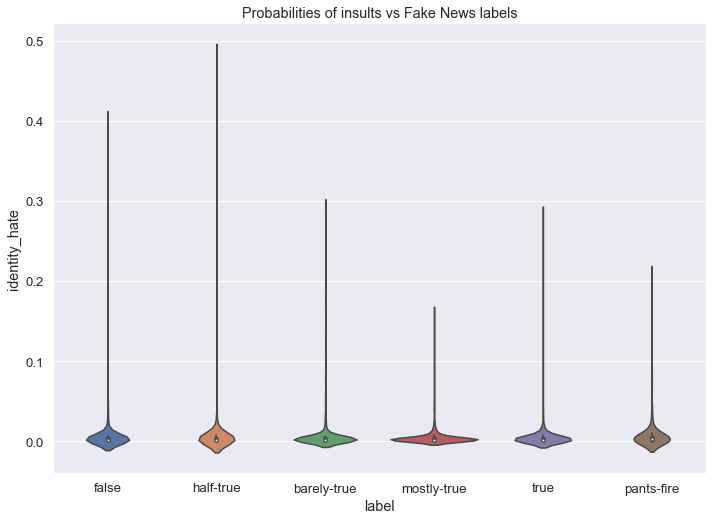

In [158]:
from matplotlib import pyplot
import seaborn


a4_dims = (11.7, 8.27)

fig, ax = pyplot.subplots(figsize=a4_dims)


#fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(14, 6))
#axx=ax.flat

th=0.001
cat= 'identity_hate'

_df = df[ (df[cat]>th)  ] 



sns.violinplot(ax= ax, y=cat,x= 'label' , data= _df, kind="box", sizes=(20, 20))
sns.set(font_scale=1.2)

plt.title('Probabilities of insults vs Fake News labels')

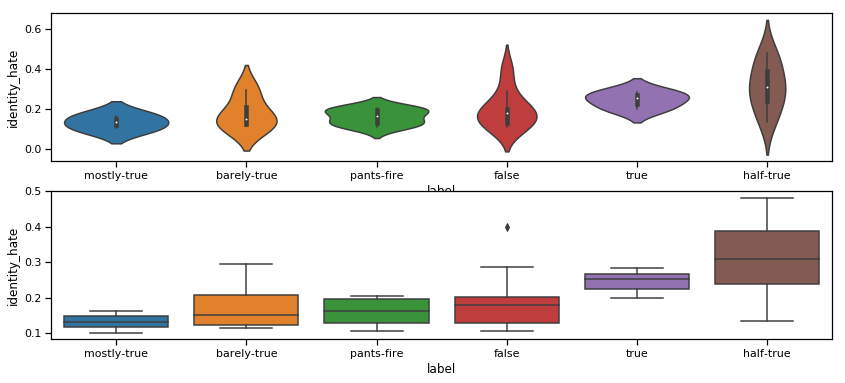

In [149]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.1
cat= 'identity_hate'

_df = df[ (df[cat]>th)  ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

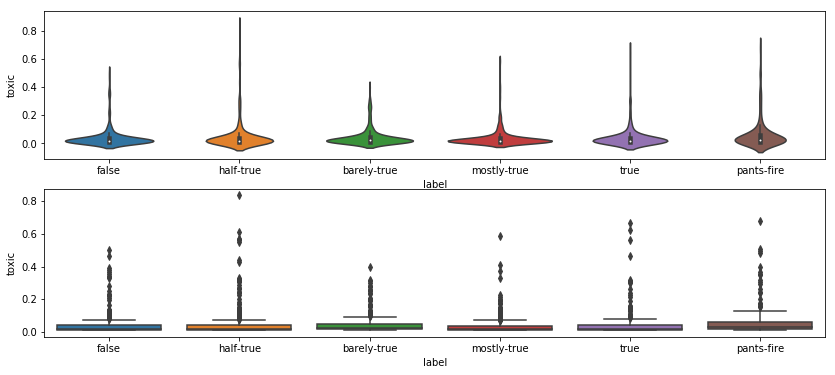

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.01
cat= 'toxic'

_df = df[ (df[cat]>th) ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

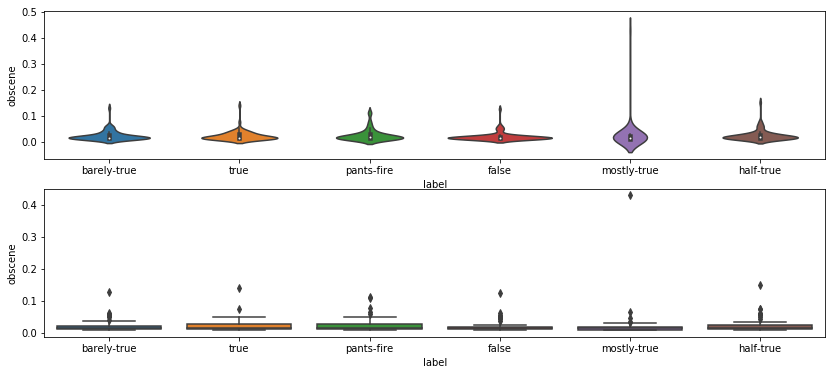

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.01
cat= 'obscene'

_df = df[ (df[cat]>th) ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

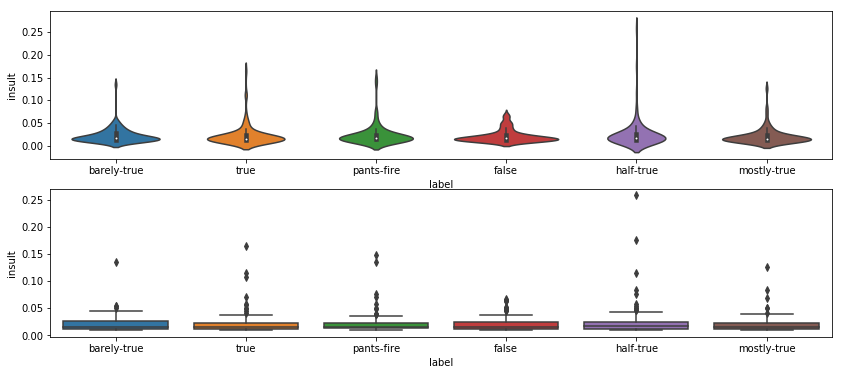

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.01
cat= 'insult'

_df = df[ (df[cat]>th) ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

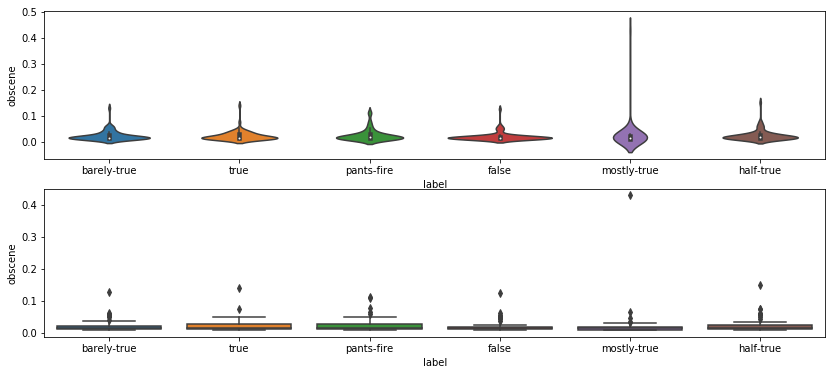

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.01
cat= 'obscene'

_df = df[ (df[cat]>th) ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

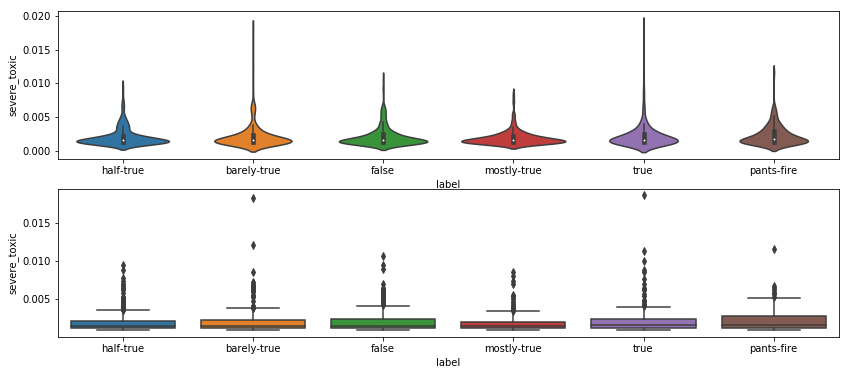

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(14, 6))
axx=ax.flat

th=0.001
cat= 'severe_toxic'

_df = df[ (df[cat]>th) ] 

sns.violinplot(y=cat,x= 'label' , data= _df, kind="box", ax=axx[0])


sns.catplot(y=cat,x= 'label' , data=_df, kind="box", ax=axx[1])

plt.close(2);

# Reliable/Unreliable

In [60]:

dataFields = {"statement": ("statement", TEXT)}

testDataset= data.TabularDataset(path='./data/reliable-unreliable/train.json', 
                                            format='json',
                                            fields=dataFields, 
                                            skip_header=False)
test_iterator = torchtext.data.Iterator(testDataset, batch_size=64, device=device, 
                                     sort=False, sort_within_batch=False, 
                                     repeat=False,shuffle=False)

myPreds=[]
with torch.no_grad():
    model.eval()
    for batch in test_iterator:

        torch.cuda.empty_cache()
    
        text = batch.statement    
        predictions = model(text).squeeze(1)         
        myPreds+=[torch.sigmoid(predictions).detach().numpy()]
    
        torch.cuda.empty_cache()
myPreds = np.vstack(myPreds)

In [61]:
tox_cols= ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
df = pd.read_csv("./data/reliable-unreliable/train_preprocessed.csv")
for i, col in enumerate(tox_cols):
    df[col] = myPreds[:, i]

In [90]:
df['reliable'] = df['label'].apply(lambda x: 'reliable' if x==0 else 'unreliable')

In [91]:
df[ df['insult'] > 0.1 ].describe()

,id,label,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,9980.436170,0.659574,0.791583,0.007565,0.326252,0.004315,0.245400,0.030362
std,5675.351334,0.476393,0.173539,0.017163,0.273278,0.011808,0.178825,0.062341
min,566.000000,0.000000,0.286296,0.000439,0.014743,0.000070,0.101064,0.001296
25%,5085.250000,0.000000,0.678039,0.002031,0.081788,0.000457,0.122419,0.003496
50%,9843.000000,1.000000,0.834578,0.003823,0.273034,0.000834,0.174283,0.007346
75%,14820.500000,1.000000,0.929057,0.007392,0.486948,0.001925,0.318898,0.023118
max,20793.000000,1.000000,0.999763,0.150788,0.987258,0.088688,0.968108,0.401822


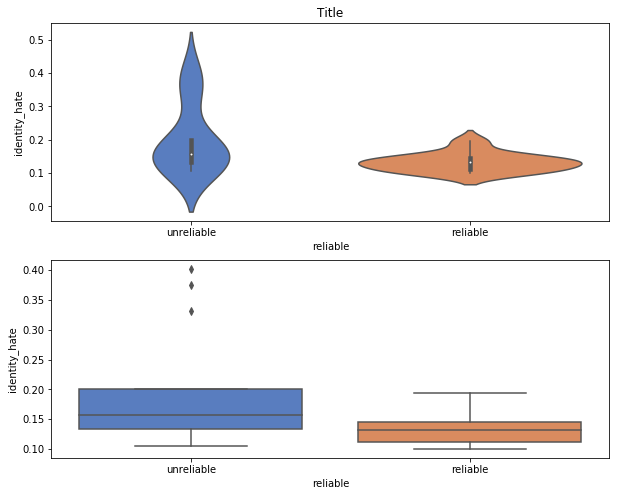

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(10, 8))
axx=ax.flat

th=0.1
cat= 'identity_hate'

_df = df[ (df[cat]>th)  ] 

g = sns.violinplot(y=cat,x= 'reliable' , data= _df, kind="box", ax=axx[0], palette="muted")

g.set_title("Title")


sns.catplot(y=cat,x= 'reliable' , data=_df, kind="box", ax=axx[1], palette="muted")


g.set_title("Title")
plt.close(2);